# RAPIDS Install

In [1]:
# # This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# # Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/env-check.py

# # This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
# !bash rapidsai-csp-utils/colab/update_gcc.sh
# import os
# os._exit(00)

In [2]:
# # This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
# import condacolab
# condacolab.install()

In [3]:
# # you can now run the rest of the cells as normal
# import condacolab
# condacolab.check()

# # Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# # The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# !python rapidsai-csp-utils/colab/install_rapids.py stable

# Setup

In [6]:
import os
# python global seed
os.environ['PYTHONHASHSEED'] = str(42)
# tensorflow seed (not working for GPU)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
# weight and bias
os.environ["WANDB_API_KEY"] = "b838b62906ab267778c6e05b913ba6c4a27699b2"

In [7]:
from google.colab import drive
drive.mount('/content/drive')
# # TextVectorization layer in tf 2.6 don't support "sparse=True" option which is used on TF-IDF
# # !pip install -q tensorflow==2.6.0
!pip install -q tensorflow==2.8
!pip install -q tensorflow-recommenders==0.6
# !pip install -q scann==1.2.3
# !pip install -q scann==1.2.6
# # !pip install -q tensorflow-datasets
!pip install -q tensorflow-addons
# !pip install -q tensorflow-hub
# # !pip install -q keras-tuner

!pip install -q transformers

!pip install -q statsmodels
# !pip install -q xgboost
# !pip install -q lightgbm
# !pip install -q catboost
# !pip install -q missingpy

!pip install -q optuna
!pip install -q wandb

Mounted at /content/drive
     / 668.3 MB 413 kB/s
     |████████████████████████████████| 462 kB 6.8 MB/s 
     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 8.6 MB/s 
     |████████████████████████████████| 4.2 MB 8.0 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 59.9 MB/s 
     |████████████████████████████████| 596 kB 92.1 MB/s 
     |████████████████████████████████| 308 kB 8.5 MB/s 
     |████████████████████████████████| 81 kB 11.7 MB/s 
     |████████████████████████████████| 209 kB 83.3 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 146 kB 89.1 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 76.9 MB/s 
     |████████████████████████████████| 1.8 MB 9.6 MB/s 
     |████████████████████████████████| 181 kB 95.6 MB/s 
     |█████████████████████████████

In [8]:
import sys
import shutil
from glob import glob
import multiprocessing as mp
import gc
from pathlib import Path
from scipy import stats
from scipy.special import boxcox, softmax
from scipy import sparse
import itertools

from multiprocessing import cpu_count
import copy
import pickle
import warnings
from datetime import datetime, timedelta
from time import time, sleep, mktime
from matplotlib import font_manager as fm, rc, rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import random as rnd
import psutil
from optuna import Trial, create_study
from optuna.samplers import TPESampler
import wandb

import numpy as np
from numpy import array, nan, random as np_rnd, where
from numpy import dot
from numpy.linalg import norm
import pandas as pd
from pandas import DataFrame as dataframe, Series as series, isna, read_csv
from pandas.tseries.offsets import DateOffset

from sklearn.model_selection import train_test_split as tts, StratifiedKFold, GroupKFold, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
from sklearn import metrics
# from sklearn.compose import ColumnTransformer
# config_missingpy(); from missingpy import MissForest
# from sklearn.impute import KNNImputer
# from sklearn.feature_extraction.text import TfidfVectorizer

# try:
#     # RAPIDS config
#     os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
#     os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
#     os.environ['CONDA_PREFIX'] = '/usr/local'
#     import cudf as cd
#     import cupy as cp
#     from cuml.cluster import KMeans
#     from cuml.neighbors import NearestNeighbors
#     from cuml.metrics.cluster import silhouette_score
# except:
#     print("RAPIDS Import ERROR")

# import xgboost as xgb
# import lightgbm as lgb
# import catboost as cat

# ===== tensorflow =====
import tensorflow as tf
from tensorflow import random as tf_rnd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import metrics as tf_metrics
from tensorflow.keras import callbacks as tf_callbacks
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from keras.utils.layer_utils import count_params

# import keras_tuner as kt
# from keras_tuner import HyperModel
# import tensorflow_hub as tf_hub
import tensorflow_recommenders as tfrs

# # ===== pytorch =====
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModel

# GPU memory setting
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

warnings.filterwarnings(action='ignore')
rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 200)
# plt.rc('font', family='NanumSquareB')

In [9]:
# ===== utility functions =====
# label encoding for categorical column with excepting na value
def seed_everything(seed=42):
    # python random module
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # RAPIDS random
    try:
        cp.random.seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
    except:
        pass
def which(bool_list):
    return where(bool_list)[0]
def easyIO(x=None, path=None, op="r"):
    tmp = None
    if op == "r":
        with open(path, "rb") as f:
            tmp = pickle.load(f)
        return tmp
    elif op == "w":
        with open(path, "wb") as f:
            pickle.dump(x, f)
    else:
        print("Unknown operation type")
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]
def orderElems(for_order, using_ref):
    return [i for i in using_ref if i in for_order]
# concatenate by row
def cbr(df1, df2):
    if type(df1) == series:
        tmp_concat = series(pd.concat([dataframe(df1), dataframe(df2)], axis=0, ignore_index=True).iloc[:,0])
        tmp_concat.reset_index(drop=True, inplace=True)
    elif type(df1) == dataframe:
        tmp_concat = pd.concat([df1, df2], axis=0, ignore_index=True)
        tmp_concat.reset_index(drop=True, inplace=True)
    elif type(df1) == np.ndarray:
        tmp_concat = np.concatenate([df1, df2], axis=0)
    else:
        print("Unknown Type: return 1st argument")
        tmp_concat = df1
    return tmp_concat
def change_width(ax, new_value):
    for patch in ax.patches :
        current_width = patch.get_width()
        adj_value = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + adj_value * .5)
def week_of_month(date):
    month = date.month
    week = 0
    while date.month == month:
        week += 1
        date -= timedelta(days=7)
    return week
def getSeason(date):
    month = date.month
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return "Winter"
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
# def softmax(x):
#     max = np.max(x, axis=1, keepdims=True)  # returns max of each row and keeps same dims
#     e_x = np.exp(x - max)  # subtracts each row with its max value
#     sum = np.sum(e_x, axis=1, keepdims=True)  # returns sum of each row and keeps same dims
#     f_x = e_x / sum
#     return f_x
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def dispPerformance(result_dic):
    perf_table = dataframe()
    index_names = []
    for k, v in result_dic.items():
        index_names.append(k)
        perf_table = pd.concat([perf_table, series(v["performance"]).to_frame().T], ignore_index=True, axis=0)
    perf_table.index = index_names
    perf_table.sort_values(perf_table.columns[0], inplace=True)
    print(perf_table)
    return perf_table
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)
def xgb_custom_lossfunction(alpha = 1):
    def support_under_mse(label, pred):
        # grad : 1차 미분
        # hess : 2차 미분
        residual = (label - pred).astype("float")
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * alpha, 2.0)
        return grad, hess
    return support_under_mse
def pd_flatten(df):
    df = df.unstack()
    df.index = [str(i) + "_" + str(j) for i, j in df.index]
    return df
def tf_losses_rmse(y_true, y_pred, sample_weight=None):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred) ** 2)) if sample_weight is None else tf.sqrt(tf.reduce_mean(((y_true - y_pred) ** 2) * sample_weight))
def tf_loss_nmae(y_true, y_pred, sample_weight=False):
    mae = tf.reduce_mean(tf.math.abs(y_true - y_pred))
    score = tf.math.divide(mae, tf.reduce_mean(tf.math.abs(y_true)))
    return score
def text_extractor(string, lang="eng", spacing=True):
    # # 괄호를 포함한 괄호 안 문자 제거 정규식
    # re.sub(r'\([^)]*\)', '', remove_text)
    # # <>를 포함한 <> 안 문자 제거 정규식
    # re.sub(r'\<[^)]*\>', '', remove_text)
    if lang == "eng":
        text_finder = re.compile('[^ A-Za-z]') if spacing else re.compile('[^A-Za-z]')
    elif lang == "kor":
        text_finder = re.compile('[^ ㄱ-ㅣ가-힣+]') if spacing else re.compile('[^ㄱ-ㅣ가-힣+]')
    # default : kor + eng
    else:
        text_finder = re.compile('[^ A-Za-zㄱ-ㅣ가-힣+]') if spacing else re.compile('[^A-Za-zㄱ-ㅣ가-힣+]')
    return text_finder.sub('', string)
def memory_usage(message='debug'):
    # current process RAM usage
    p = psutil.Process()
    rss = p.memory_info().rss / 2 ** 20 # Bytes to MB
    print(f"[{message}] memory usage: {rss: 10.3f} MB")
    return rss
def cos_sim(a, b):
  return dot(a, b)/(norm(a) * norm(b))
class MyLabelEncoder:
    def __init__(self, preset={}):
        # dic_cat format -> {"col_name": {"value": replace}}
        self.dic_cat = preset
    def fit_transform(self, data_x, col_names):
        tmp_x = copy.deepcopy(data_x)
        for i in col_names:
            # if key is not in dic, update dic
            if i not in self.dic_cat.keys():
                tmp_dic = dict.fromkeys(sorted(set(tmp_x[i]).difference([nan])))
                label_cnt = 0
                for j in tmp_dic.keys():
                    tmp_dic[j] = label_cnt
                    label_cnt += 1
                self.dic_cat[i] = tmp_dic
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def transform(self, data_x):
        tmp_x = copy.deepcopy(data_x)
        for i in self.dic_cat.keys():
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def clear(self):
        self.dic_cat = {}
class MyOneHotEncoder:
    def __init__(self, label_preset={}):
        self.dic_cat = {}
        self.label_preset = label_preset
    def fit_transform(self, data_x, col_names):
        tmp_x = dataframe()
        for i in data_x:
            if i not in col_names:
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                self.dic_cat[i] = OneHotEncoder(sparse=False, handle_unknown="ignore")
                conv = self.dic_cat[i].fit_transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j:
                                col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def transform(self, data_x):
        tmp_x = dataframe()
        for i in data_x:
            if not i in list(self.dic_cat.keys()):
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                conv = self.dic_cat[i].transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j: col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def clear(self):
        self.dic_cat = {}
        self.label_preset = {}
class MyKNNImputer:
    def __init__(self, k=5):
        self.imputer = KNNImputer(n_neighbors=k)
        self.dic_cat = {}
    def fit_transform(self, x, cat_vars=None):
        if cat_vars is None:
            x_imp = dataframe(self.imputer.fit_transform(x), columns=x.columns)
        else:
            naIdx = dict.fromkeys(cat_vars)
            for i in cat_vars:
                self.dic_cat[i] = diff(list(sorted(set(x[i]))), [nan])
                naIdx[i] = list(which(array(x[i].isna())))
            x_imp = dataframe(self.imputer.fit_transform(x), columns=x.columns)

            # if imputed categorical value are not in the range, adjust the value
            for i in cat_vars:
                x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
                for j in naIdx[i]:
                    if x_imp[i][j] not in self.dic_cat[i]:
                        if x_imp[i][j] < self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][0]
                        elif x_imp[i][j] > self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][len(self.dic_cat[i]) - 1]
        return x_imp
    def transform(self, x):
        if len(self.dic_cat.keys()) == 0:
            x_imp = dataframe(self.imputer.transform(x), columns=x.columns)
        else:
            naIdx = dict.fromkeys(self.dic_cat.keys())
            for i in self.dic_cat.keys():
                naIdx[i] = list(which(array(x[i].isna())))
            x_imp = dataframe(self.imputer.transform(x), columns=x.columns)

            # if imputed categorical value are not in the range, adjust the value
            for i in self.dic_cat.keys():
                x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
                for j in naIdx[i]:
                    if x_imp[i][j] not in self.dic_cat[i]:
                        if x_imp[i][j] < self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][0]
                        elif x_imp[i][j] > self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][len(self.dic_cat[i]) - 1]
        return x_imp
    def clear(self):
        self.imputer = None
        self.dic_cat = {}
def remove_outlier(df, std=3, mode="remove"):
    tmp_df = df.copy()
    if mode == "remove":
        outlier_mask = (np.abs(stats.zscore(tmp_df)) > std).all(axis=1)
        print("found outlier :", outlier_mask.sum())
        tmp_df = tmp_df[~outlier_mask]
    elif mode == "interpolate":
        tmp_outlier = []
        for i in tmp_df:
            outlier_mask = (np.abs(stats.zscore(tmp_df[i])) > std)
            tmp_outlier.append(outlier_mask.sum())
            if tmp_outlier[-1] == 0:
                continue
            tmp_df[i][outlier_mask] = np.nan
            tmp_df[i] = tmp_df[i].interpolate(method='linear').bfill()
        print("found outlier :", np.sum(outlier_mask))
    return tmp_df
def convert_sparse_matrix_to_sparse_tensor(X, sorted=True):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape)) if sorted else tf.SparseTensor(indices, coo.data, coo.shape)
seed_everything()

In [10]:
class RandomInputExchange(tf.keras.layers.Layer):
    def __init__(self, target_point, rate, **kwargs):
        super(RandomInputExchange, self).__init__(**kwargs)
        self.target_point = target_point
        self.rate = rate
    def call(self, inputs, training=True):
        if training:
            outputs = tf.cond(tf.math.less(tf.random.uniform(shape=[]), self.rate),
                    lambda: tf.concat([
                                tf.gather(inputs, tf.range(start=self.target_point, limit=tf.shape(inputs)[-1], delta=1, dtype=tf.int32), axis=-1),
                                tf.gather(inputs, tf.range(start=0, limit=self.target_point, delta=1, dtype=tf.int32), axis=-1),
                            ], axis=-1),
                    lambda: inputs)
            return outputs
        else:
            return inputs
    def get_config(self):
        config = super().get_config()
        config.update({
            "target_point": self.target_point,
            "rate": self.rate,
        })
        return config

In [11]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/projects/Dacon/code_similarity/"
code_folder = '/content/drive/MyDrive/Colab Notebooks/projects/Dacon/code_similarity/open.zip (Unzipped Files)/code/'

# Preprocessing

In [10]:
def preprocess_script(script):
    with open(script, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        preproc_lines = []
        multi_comment_flag = False
        for line in lines:    
            line = line.replace('\n','')
            line = line.replace('\t',' ')

            line = line.replace(' ;',';')
            line = line.replace('; ',';')
            line = line.replace(';',' ')

            line = line.replace(' :',':')
            line = line.replace(': ',':')
            line = line.replace(':',': ')

            line = line.replace('&&',' and ')
            line = line.replace('||',' or ')

            line = " ".join(line.split())

            if 'from' in line or 'import' in line:
                continue

            if '#' in line:
                line = line[:line.index('#')]
                if line == '':
                    continue
        
            if multi_comment_flag:
                if '"""' in line:
                    try:
                        line = line[line.index('"""')+3:]
                    except:
                        line == ''
                    multi_comment_flag = False
                elif "'''" in line:
                    try:
                        line = line[line.index("'''")+3:]
                    except:
                        line == ''
                    multi_comment_flag = False
                else:
                    continue
                if line == '':
                    continue

            if not multi_comment_flag:
                if '"""' in line:
                    if line.count('"""') == 1:
                        multi_comment_flag = True
                    line = line[:line.index('"""')]
                elif "'''" in line:
                    if line.count("'''") == 1:
                        multi_comment_flag = True
                    line = line[:line.index("'''")]
                if line == '':
                    continue

            line = line.replace(' ,',',')
            line = line.replace(', ',',')

            line = line.replace(' +','+')
            line = line.replace('+ ','+')

            line = line.replace(' -','-')
            line = line.replace('- ','-')

            line = line.replace(' *','*')
            line = line.replace('* ','*')

            line = line.replace(' /','/')
            line = line.replace('/ ','/')

            line = line.replace(' %','%')
            line = line.replace('% ','%')

            line = line.replace(' >','>')
            line = line.replace('> ','>')

            line = line.replace(' <','<')
            line = line.replace('< ','<')

            line = line.replace(' =','=')
            line = line.replace('= ','=')

            line = line.replace(' &','&')
            line = line.replace('& ','&')

            line = line.replace(' |','|')
            line = line.replace('| ','|')

            line = line.replace(' !','!')
            line = line.replace('! ','!')

            # line = line.replace(' (','(')
            line = line.replace('( ','(')

            line = line.replace(' )',')')
            # line = line.replace(') ',')')

            # line = line.replace(' {','{')
            line = line.replace('{ ','{')

            line = line.replace(' }','}')
            # line = line.replace('} ','}')

            # line = line.replace(' [','[')
            line = line.replace('[ ','[')

            line = line.replace(' ]',']')
            # line = line.replace('] ',']')

            if (line == "main()") or ("def main():" in line) or ('if __name__=="__main__":' in line) or ("if __name__=='__main__':" in line):
                continue

            preproc_lines.append(line)
        preprocessed_script = ' '.join(preproc_lines)
        preprocessed_script = ' '.join(preprocessed_script.split())
    return preprocessed_script

In [11]:
problem_folders = os.listdir(code_folder)
preproc_scripts = []
problem_idx = []
problem_group = []

cnt = 0
for problem_folder in tqdm(problem_folders):
    scripts = os.listdir(os.path.join(code_folder,problem_folder))
    problem_num = scripts[0].split('_')[0]
    for script in scripts:
        script_file = os.path.join(code_folder,problem_folder,script)
        preprocessed_script = preprocess_script(script_file)
        preproc_scripts.append(preprocessed_script)
        problem_idx.append(script.split('.')[0])
        cnt += 1
    problem_group.extend([problem_num] * len(scripts))

100%|██████████| 300/300 [11:22<00:00,  2.27s/it]


In [12]:
df_full = pd.DataFrame(data = {'code':preproc_scripts, 'problem_idx':problem_idx, "problem_group":problem_group})

In [13]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45101 entries, 0 to 45100
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   code           45101 non-null  object
 1   problem_idx    45101 non-null  object
 2   problem_group  45101 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [14]:
df_full.head()

,code,problem_idx,problem_group
0,"for i in range(1,10): for n in range(1,10): print(""%dx%d=%d""%(i,n,i*n))",problem001_101,problem001
1,"for x in range(1,10): for y in range(1,10): print ""{}x{}={}"".format(x,y,x*y)",problem001_100,problem001
2,"list1=range(1,10) list2=list1 for i in list1: for j in list2: print str(i)+""x""+str(j)+""=""+str(i*j)",problem001_10,problem001
3,"M=9 N=9 for i in range(1,M+1,1): for j in range(1,N+1,1): mult=i*j print(str(i)+""x""+str(j)+""=""+str(i*j))",problem001_1,problem001
4,"for i in range(1,10): for k in range(1,10): print(""{0}x{1}={2}"".format(i,k,i*k))",problem001_102,problem001


In [15]:
df_full.tail()

,code,problem_idx,problem_group
45096,"n=int(input()) inlis=list(map(int,input().split())) anslis=[0]*n for i in range(n): num=inlis[i] anslis[num-1]=i+1 print(*anslis)",problem299_95,problem299
45097,"N=int(input()) A=list(map(int,input().split())) A.insert(0,0) A=[(i,A[i]) for i in range(N+1)] A=sorted(A,key=lambda x: x[1]) B=[] for i in range(1,N+1): B.append(A[i][0]) print(*B)",problem299_96,problem299
45098,"N=int(input()) A=map(int,input().split()) A=list(A) ans=[0]*len(A) for i,a in enumerate(A): ans[a-1]=i+1 print(' '.join(map(str,ans)))",problem299_97,problem299
45099,N=int(input()) list=input().split() answer=[0]*N for i in range(N): answer[int(list[i])-1]=str(i+1) print(' '.join(answer)),problem299_98,problem299
45100,"n=int(input()) a=[int(x) for x in input().split()] ans=[0]*n for i in range(n): ans[a[i]-1]=i+1 ans=[str(x) for x in ans] print("" "".join(ans))",problem299_99,problem299


In [16]:
df_full.sample(10, random_state=42)

,code,problem_idx,problem_group
22194,"A,B,C,K=map(int,input().split()) if A>=K: print(K) else: K=K-A if B>=K: print(A) else: K=K-B print(A-K)",problem148_42,problem148
6100,"W,H,x,y,r=map(int,raw_input().split()) ret=""Yes"" if W<x+r or x-r<0: ret=""No"" elif H<y+r or y-r<0: ret=""No"" print ret",problem041_40,problem041
25272,"N=int(input()) A_ls=map(int,input().split(' ')) ls=[0]*N for i in A_ls: ls[i-1]+=1 for i in ls: print(i)",problem169_105,problem169
28986,"H,W,K=list(map(int,input().split())) arr=[] for i in range(H): arr.append(list(map(int,list(input())))) def cut_sum(arr,x1,x2,y): ret=0 for i in range(x1,x2): ret+=arr[i][y] return ret row_idxes=l...",problem193_65,problem193
12465,"N=int(input()) A=list(map(int,input().split())) mod=1000000000+7 add=0 tmp=sum(A) for i in range(N): tmp-=A[i] add+=tmp*A[i] print(add%mod)",problem083_82,problem083
3619,"n=int(input()) a=list(map(int,input().split())) q=int(input()) m=list(map(int,input().split())) s=[list(map(int,bin(x)[2:].zfill(n))) for x in range(2**n)] anset=set() for j in s: ans=0 for k in r...",problem025_108,problem025
16243,"n=int(input()) res={""AC"": 0,""WA"": 0,""TLE"": 0,""RE"": 0} for _ in range(n): seq=input() res[seq]+=1 for key in res.keys(): print(f""{key} x {res[key]}"")",problem109_10,problem109
9312,x=1 while x!='0': x=input() if x!='0': sum=0 for s in x: sum+=int(s) print(sum),problem062_88,problem062
38275,n=int(input()) s=input().split() a=s[0] b=s[1] ans='' for i in range(len(a)): ans+=a[i] ans+=b[i] print (ans),problem255_41,problem255
30443,"a,b=[int(i) for i in input().split()] lo=max(1000*a,800*b) hi=min(1000*(a+1),800*(b+1)) if lo<hi: print(math.ceil(lo/80)) else: print(-1)",problem203_24,problem203


In [17]:
def test_preprocess_script(script):
    preproc_lines = []
    multi_comment_flag = False
    for line in script.split("\n"):
        line = line.replace('\n','')
        line = line.replace('\t',' ')

        line = line.replace(' ;',';')
        line = line.replace('; ',';')
        line = line.replace(';',' ')

        line = line.replace(' :',':')
        line = line.replace(': ',':')
        line = line.replace(':',': ')

        line = line.replace('&&',' and ')
        line = line.replace('||',' or ')

        line = " ".join(line.split())

        if 'from' in line or 'import' in line:
            continue

        if '#' in line:
            line = line[:line.index('#')]
            if line == '':
                continue
    
        if multi_comment_flag:
            if '"""' in line:
                try:
                    line = line[line.index('"""')+3:]
                except:
                    line == ''
                multi_comment_flag = False
            elif "'''" in line:
                try:
                    line = line[line.index("'''")+3:]
                except:
                    line == ''
                multi_comment_flag = False
            else:
                continue
            if line == '':
                continue

        if not multi_comment_flag:
            if '"""' in line:
                if line.count('"""') == 1:
                    multi_comment_flag = True
                line = line[:line.index('"""')]
            elif "'''" in line:
                if line.count("'''") == 1:
                    multi_comment_flag = True
                line = line[:line.index("'''")]
            if line == '':
                continue

        line = line.replace(' ,',',')
        line = line.replace(', ',',')

        line = line.replace(' +','+')
        line = line.replace('+ ','+')

        line = line.replace(' -','-')
        line = line.replace('- ','-')

        line = line.replace(' *','*')
        line = line.replace('* ','*')

        line = line.replace(' /','/')
        line = line.replace('/ ','/')

        line = line.replace(' %','%')
        line = line.replace('% ','%')

        line = line.replace(' >','>')
        line = line.replace('> ','>')

        line = line.replace(' <','<')
        line = line.replace('< ','<')

        line = line.replace(' =','=')
        line = line.replace('= ','=')

        line = line.replace(' &','&')
        line = line.replace('& ','&')

        line = line.replace(' |','|')
        line = line.replace('| ','|')

        line = line.replace(' !','!')
        line = line.replace('! ','!')

        # line = line.replace(' (','(')
        line = line.replace('( ','(')

        line = line.replace(' )',')')
        # line = line.replace(') ',')')

        # line = line.replace(' {','{')
        line = line.replace('{ ','{')

        line = line.replace(' }','}')
        # line = line.replace('} ','}')

        # line = line.replace(' [','[')
        line = line.replace('[ ','[')

        line = line.replace(' ]',']')
        # line = line.replace('] ',']')

        if (line == "main()") or ("def main():" in line) or ('if __name__=="__main__":' in line) or ("if __name__=='__main__':" in line):
            continue

        preproc_lines.append(line)
    preprocessed_script = ' '.join(preproc_lines)
    preprocessed_script = ' '.join(preprocessed_script.split())
    return preprocessed_script

In [18]:
df_test = read_csv(folder_path + "open.zip (Unzipped Files)/test.csv", encoding='utf-8')

In [19]:
df_test["code1"] = df_test["code1"].apply(test_preprocess_script)
df_test["code2"] = df_test["code2"].apply(test_preprocess_script)

In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179700 entries, 0 to 179699
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   pair_id  179700 non-null  int64 
 1   code1    179700 non-null  object
 2   code2    179700 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.1+ MB


In [21]:
df_test.head()

,pair_id,code1,code2
0,1,s=input() if s.count('a')==1 and s.count('b')==1 and s.count('c')==1: print('Yes') else: print('No'),"N,K=map(int,input().split()) A=list(map(int,input().split())) print((len(A)-1)//(K-1)+int(bool((len(A)-1)%(K-1))))"
1,2,"N,K,Q=map(int,input().split()) points=[0]*(N+1) for i in range(Q): a=int(input()) points[a]+=1 for i in range(1,N+1): if points[i]+K>Q: print('Yes') else: print('No')","N,K,Q=map(int,input().split()) if K>Q: for i in range(N): print(""Yes"") exit() T=[0 for i in range(N)] t=Q-K for i in range(Q): a=int(input()) T[a-1]+=1 for i in range(N): if T[i]>t: print(""Yes"") e..."
2,3,"n=int(input()) lst=[(i+1) for i in range(n)] ans=[] for x,y in combinations(lst,2): if n%2==0: if x+y==n+1: continue if n%2!=0: if x+y==n: continue ans.append((x,y)) print(len(ans)) for x,y in ans...","s=input() t=input() length_s=len(s) length_t=len(t) dp=[[0]*3005 for _ in range(3005)] for i in range(length_s): for j in range(length_t): if s[i]==t[j]: dp[i+1][j+1]=max(dp[i+1][j+1],dp[i][j]+1) ..."
3,4,"a,b=map(int,input().split()) ans1=a+b ans2=a-b ans3=a*b ans=[ans1,ans2,ans3] print(max(ans))","a,b,c,d=map(int,input().split()) if a==b: if b==c: print('Yes') elif abs(b-c)<=d: print('Yes') else: print('No') elif abs(a-b)<=d: if b==c: print('Yes') elif abs(b-c)<=d: print('Yes') else: print(..."
4,5,S=input() K=int(input()) ind=-1 for i in range(len(S)): if S[i]=='1': ind=i else: break if ind==-1: print(S[0]) elif ind+1>=K: print(1) else: print(S[ind+1]),"H,W=map(int,input().split()) grid=[] for _ in range(H): grid.append([s for s in input()]) left=[[0 for _ in range(W)] for _ in range(H)] right=[[0 for _ in range(W)] for _ in range(H)] up=[[0 for ..."


In [22]:
df_test.tail()

,pair_id,code1,code2
179695,179696,"N=int(input()) S=input() S_rep=S.replace('W','1').replace('E','0') lst1=[int(S_rep[0])] for s in S_rep[1:]: lst1.append(lst1[-1]+int(s)) ans=[N-lst1[-1]+int(S_rep[0])-1] for i in range(1,N): ans.a...",N=int(input()) S=list(input()) row=[0]*(N+2) for i in range(N): if S[i]=='E': row[i+1]=row[i]+1 else: row[i+1]=row[i] answer=[0]*N for i in range(N): answer[i]+=(i-row[i]) a=row [N]-row[i+1] answe...
179696,179697,"def input(): return sys.stdin.readline().rstrip() h,w,a,b=map(int,input().split()) S=[] for i in range(b): S.append(""1""*a+""0""*(w-a)) for i in range(h-b): S.append(""0""*a+""1""*(w-a)) for i in range(h...","h,w,a,b=(int(i) for i in input().split()) for i in range(b): print(""1""*a+""0""*(w-a)) for i in range(h-b): print(""0""*a+""1""*(w-a))"
179697,179698,"a=list(map(int,input().split())) a1=abs(a[0]-a[1]) a2=abs(a[1]-a[2]) a3=abs(a[2]-a[0]) m=max(a1,a2,a3) print(a1+a2+a3-m)","print('YNEOS'[sorted(input().split())!=['1','4','7','9']: : 2])"
179698,179699,"H,W,A,B=map(int,input().split()) s=[['0']*W for _ in range(H)] for i in range(H): for j in range(W): if i>=B and j<A: s[i][j]='1' elif i<B and j>=A: s[i][j]='1' for ss in s: tmps=''.join(ss) print...","h,w,a,b=map(int,input().split()) mat=[[0 for j in range(w)] for i in range(h)] for i in range(b,h): for j in range(a): mat[i][j]=1 for i in range(b): for j in range(a,w): mat[i][j]=1 for _ in mat:..."
179699,179700,"n,k=map(int,input().split()) MOD=1000000007 g=[[]*1 for i in range(n)] for i in range(n-1): a,b=map(int,input().split()) a-=1 b-=1 g[a].append(b) g[b].append(a) d=[-1 for i in range(n)] q=deque([]...","read=sys.stdin.readline def read_ints(): return list(map(int,read().split())) def read_matrix(H): ret=[] for _ in range(H): ret.append(list(map(int,read().split()))) return ret N,C=read_ints() D=r..."


In [23]:
df_test.sample(10, random_state=42)

,pair_id,code1,code2
94335,94336,"s=input() if int(s[6])<=4 and int(s[5])==0: print(""Heisei"") else: print(""TBD"")","s=input() if s[5: 7] in ['01','02','03']: print('Heisei') elif s[6: 7]=='4' and int(s[-2:-1])<=30: print('Heisei') else: print('TBD')"
77382,77383,"INF=float('inf') mod=10**9+7 sys.setrecursionlimit(10**6) def lcm(a,b): return a*b/gcd(a,b) def LI(): return list(map(int,sys.stdin.buffer.readline().split())) def I(): return int(sys.stdin.buffer...","H,W=[int(_) for _ in input().split()] M=[] w_count=0 for i in range(H): s=input() w_count+=s.count('.') M.append(s) visited=[[False for _ in range(W)] for _ in range(H)] q=deque([[0,0,1]]) while l..."
102576,102577,"def S(): return sys.stdin.readline().rstrip() def I(): return int(sys.stdin.readline().rstrip()) def MI(): return map(int,sys.stdin.readline().rstrip().split()) def LI(): return list(map(int,sys.s...","n=int(input()) A=list(map(int,input().split())) S=sum(A) d=10**14 for i,a in enumerate(A): if abs(a*n-S)<d: d=abs(a*n-S) ind=i print(ind)"
137626,137627,"def input(): return sys.stdin.readline().rstrip() n=int(input()) s=input() ans=0 for i in range(1,n): ans=max(ans,len(set(s[: i])&set(s[i:]))) print(ans)","def route_num(stairs): if stairs<=1: return 1 else: return route_num(stairs-1)+route_num(stairs-2) n,m=map(int,input().split()) a=[int(input()) for _ in range(m)] broken={i: False for i in range(n..."
158136,158137,"a,b=list(map(int,input().split())) print(a+int(b/2))","X,Y=list(map(int,input().split())) print(X+Y//2)"
66569,66570,"a,b=map(int,input().split()) ans1=a+b ans2=a-b ans3=a*b ans=[ans1,ans2,ans3] print(max(ans))","sys.setrecursionlimit(10**6) INF=10**20 eps=1.0e-20 MOD=10**9+7 def lcm(x,y): return x*y//gcd(x,y) def lgcd(l): return reduce(gcd,l) def llcm(l): return reduce(lcm,l) def mint(): return map(int,in..."
72640,72641,"a,b,k=map(int,input().split()) k=min(k,b-a+1) *al,=range(a,a+k) *al2,=range(b-k+1,b+1) ans=al+al2 ans=list(set(ans)) ans.sort() for i in ans: print(i)","A,B,K=map(int,input().split()) if A==B: print(A) exit() if B-A<K: K=B-A l=list() for i in range(A,A+K): l.append(i) for i in range(B-K+1,B+1): l.append(i) l=set(l) l=sorted(l) for i in range(len(l..."
65099,65100,"N=int(input()) H=list(map(int,input().split())) for i in range(N-1,0,-1): if H[i]+1<H[i-1]: print('No') exit(0) elif H[i]+1==H[i-1]: H[i-1]-=1 print('Yes')","C=[list(map(int,input().split())) for i in range(3)] A=[] B=[] for i in range(3): A.append([C[0][i]-C[1][i],C[1][i]-C[2][i],C[2][i]-C[0][i]]) for i in range(3): B.append([C[i][0]-C[i][1],C[i][1]-C..."
174458,174459,"n=int(input()) s=str(input()) s=s.replace(""W"",""1"") s=s.replace(""E"",""0"") fl=sum(list(map(int,s))) k=0 p=0 for i in range(n): if i==0: p=fl-int(s[0]) k=p elif i==n-1: p=n-1-fl+int(s[n-1]) if p>k: k=...","n=int(input()) c1=0 c2=0 c3=0 ans=0 for i in range(n): s=input() if s[0]==""B"" and s[-1]==""A"": c1+=1 if s[0]==""B"" and s[-1]!=""A"": c2+=1 if s[0]!=""B"" and s[-1]==""A"": c3+=1 for j in range(len(s)-1): ..."
151217,151218,"class UnionFind(): def __init__(self,n): self.n=n self.parents=[-1]*n def find(self,x): if self.parents[x]<0: return x else: self.parents[x]=self.find(self.parents[x]) return self.parents[x] def u...","class UnionFind(): def __init__(self,n): self.n=n self.parents=[-1]*n def find(self,x): if self.parents[x]<0: return x else: self.parents[x]=self.find(self.parents[x]) return self.parents[x] def u..."


# save data

In [24]:
MAX_LEN = 256
torch_device = torch.device('cuda')
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
MAX_VOCAB = len(tokenizer.vocab)
code_bert = AutoModel.from_pretrained("microsoft/codebert-base").to(torch_device)

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [25]:
def get_bert_fv(x, batch_size=32):
    tmp = []
    dataloader = DataLoader(x, batch_size, shuffle=False)
    for idx, value in enumerate(tqdm(dataloader)):  
        inputs = tokenizer.batch_encode_plus(
            value,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding="max_length",
            return_token_type_ids=False,
            truncation=True
        )
        input_ids = torch.tensor(inputs['input_ids']).to(torch_device)
        outputs = code_bert(input_ids)
        np_value = outputs.pooler_output.detach().cpu().numpy()
        tmp.append(np_value)
    torch.cuda.empty_cache()
    return np.concatenate(tmp, axis=0)

In [26]:
df_full['tokens'] = df_full['code'].apply(lambda x: tokenizer.tokenize(x))

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


In [27]:
# # drop samples of which length is more than MAX_LEN
# df_full = df_full[df_full['len'] <= MAX_LEN].reset_index(drop=True)
# df_full = df_full[df_full['len'] != 0.0].reset_index(drop=True)
# # drop samples of which problem group units is less than 2
# tmp_vec = df_full["problem_group"].value_counts().index[df_full["problem_group"].value_counts() < 2]
# df_full = df_full[df_full["problem_group"].apply(lambda x: False if x in tmp_vec else True)].reset_index(drop=True)
# df_full.describe()

In [28]:
# df_full.set_index(["problem_group", "problem_idx"], inplace=True)
# df_full.info()

In [29]:
df_test['tokens1'] = df_test['code1'].apply(lambda x: tokenizer.tokenize(x))
df_test['tokens2'] = df_test['code2'].apply(lambda x: tokenizer.tokenize(x))

**train data save**

In [30]:
# df_full_fv = get_bert_fv(df_full["code"].to_list(), 16)

In [31]:
# easyIO(df_full_fv, folder_path + "datasets/corpus_full_fv.pkl", "w"); del df_full_fv

In [32]:
# df_full.drop("code", axis=1, inplace=True)
# easyIO(df_full, folder_path + "datasets/corpus_full.pkl", "w"); del df_full

In [33]:
# # df_full.drop("code", axis=1, inplace=True)
# easyIO(df_full, folder_path + "datasets/corpus_full_tokens.pkl", "w"); del df_full

In [34]:
df_full_fv = get_bert_fv(df_full["code"].to_list(), 32)

100%|██████████| 1410/1410 [10:55<00:00,  2.15it/s]


In [35]:
easyIO(df_full, folder_path + "datasets/corpus_full_tokens_prepV2.pkl", "w")
easyIO(df_full_fv, folder_path + "datasets/corpus_full_tokens_fvV2.pkl", "w")
del df_full, df_full_fv

**test data save**

In [36]:
# tmp_fv = get_bert_fv(df_test["code1"].to_list(), 16)
# easyIO(tmp_fv, folder_path + "datasets/corpus_test_fv_code1.pkl", "w")

In [37]:
# tmp_fv = get_bert_fv(df_test["code2"].to_list(), 16)
# easyIO(tmp_fv, folder_path + "datasets/corpus_test_fv_code2.pkl", "w")

In [38]:
# df_test.drop(["code1", "code2"], axis=1, inplace=True)
# easyIO(df_test, folder_path + "datasets/corpus_test.pkl", "w"); del df_test

In [39]:
# easyIO(df_test, folder_path + "datasets/corpus_test_tokens.pkl", "w"); del df_test

In [40]:
df_test_fv1 = get_bert_fv(df_test["code1"].to_list(), 32)
df_test_fv2 = get_bert_fv(df_test["code2"].to_list(), 32)

100%|██████████| 5616/5616 [43:29<00:00,  2.15it/s]


In [41]:
easyIO(df_test, folder_path + "datasets/corpus_test_tokens_prepV2.pkl", "w")
easyIO(df_test_fv1, folder_path + "datasets/corpus_test_tokens_fv1V2.pkl", "w")
easyIO(df_test_fv2, folder_path + "datasets/corpus_test_tokens_fv2V2.pkl", "w")
del df_test, df_test_fv1, df_test_fv2

# quick start session

In [12]:
MAX_LEN = 256

In [13]:
# df_full = easyIO(None, folder_path + "datasets/corpus_full.pkl", "r")
# df_full_fv = easyIO(None, folder_path + "datasets/corpus_full_fv.pkl", "r")
# df_full = easyIO(None, folder_path + "datasets/corpus_full_tokens.pkl", "r")
df_full = easyIO(None, folder_path + "datasets/corpus_full_tokens_prepV2.pkl", "r")
df_full_fv = easyIO(None, folder_path + "datasets/corpus_full_tokens_fvV2.pkl", "r")

In [14]:
df_full['len'] = df_full['tokens'].apply(lambda x: len(x))

In [15]:
# # drop samples of which length is more than MAX_LEN * 2
df_full_fv = df_full_fv[(df_full['len'] <= int(MAX_LEN * 2)) & (df_full['len'] != 0.0)]
df_full = df_full[(df_full['len'] <= int(MAX_LEN * 2)) & (df_full['len'] != 0.0)].reset_index(drop=True)
# df_full = df_full[(df_full['len'] != 0.0)].reset_index(drop=True)

# drop samples of which problem group units is less than 2
tmp_vec = df_full["problem_group"].value_counts().index[df_full["problem_group"].value_counts() < 2]
df_full_fv = df_full_fv[df_full["problem_group"].apply(lambda x: False if x in tmp_vec else True)]
df_full = df_full[df_full["problem_group"].apply(lambda x: False if x in tmp_vec else True)]
df_full['len'].describe()

count    44598.000000
mean       113.190659
std         89.620236
min          5.000000
25%         49.000000
50%         84.000000
75%        149.000000
max        512.000000
Name: len, dtype: float64

In [16]:
df_full.set_index(["problem_group", "problem_idx"], inplace=True)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 44598 entries, ('problem001', 'problem001_101') to ('problem299', 'problem299_99')
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   code    44598 non-null  object
 1   tokens  44598 non-null  object
 2   len     44598 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


In [17]:
df_full.shape

(44598, 3)

In [18]:
df_full.head()

code                                                                                                                                                                                                   tokens  len
problem_group problem_idx                                                                                                                                                                                                                                                                                                                           
problem001    problem001_101                                   for i in range(1,10): for n in range(1,10): print("%dx%d=%d"%(i,n,i*n))                                                      [for, Ġi, Ġin, Ġrange, (, 1, ,, 10, ):, Ġfor, Ġn, Ġin, Ġrange, (, 1, ,, 10, ):, Ġprint, (", %, dx, %, d, =, %, d, ", %, (, i, ,, n, ,, i, *, n, ))]   38
              problem001_100                              for x in range(1,10): for y in range(1,10): print "{}x{}={}".format(x,y,x*y)                                                   [for, Ġx, Ġin, Ġrange, (, 1, ,, 10, ):, Ġfor, Ġy, Ġin, Ġrange, (, 1, ,, 10, ):, Ġprint, Ġ"{, }, x, {, }, ={, }, "., format, (, x, ,, y, ,, x, *, y, )]   37
              problem001_10         list1=range(1,10) list2=list1 for i in list1: for j in list2: print str(i)+"x"+str(j)+"="+str(i*j)       [list, 1, =, range, (, 1, ,, 10, ), Ġlist, 2, =, list, 1, Ġfor, Ġi, Ġin, Ġlist, 1, :, Ġfor, Ġj, Ġin, Ġlist, 2, :, Ġprint, Ġstr, (, i, )+, ", x, ", +, str, (, j, )+, ", =", +, str, (, i, *, j, )]   48
              problem001_1    M=9 N=9 for i in range(1,M+1,1): for j in range(1,N+1,1): mult=i*j print(str(i)+"x"+str(j)+"="+str(i*j))  [M, =, 9, ĠN, =, 9, Ġfor, Ġi, Ġin, Ġrange, (, 1, ,, M, +, 1, ,, 1, ):, Ġfor, Ġj, Ġin, Ġrange, (, 1, ,, N, +, 1, ,, 1, ):, Ġmult, =, i, *, j, Ġprint, (, str, (, i, )+, ", x, ", +, str, (, j, )+, ",...   60
              problem001_102                          for i in range(1,10): for k in range(1,10): print("{0}x{1}={2}".format(i,k,i*k))                                       [for, Ġi, Ġin, Ġrange, (, 1, ,, 10, ):, Ġfor, Ġk, Ġin, Ġrange, (, 1, ,, 10, ):, Ġprint, (", {, 0, }, x, {, 1, }, ={, 2, }, "., format, (, i, ,, k, ,, i, *, k, ))]   41

In [19]:
df_full.drop(["code", "tokens", "len"], axis=1, inplace=True)

In [20]:
# from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
# tfidf = TfidfVectorizer(ngram_range=(1,4), min_df=0.001, dtype="float32")
# tfidf.fit(df_full["tokens"].apply(lambda x: " ".join(x)))
# df_full_fv = tfidf.fit_transform(df_full["tokens"].apply(lambda x: " ".join(x)))

In [22]:
# len(tfidf.vocabulary_)

In [23]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 44598 entries, ('problem001', 'problem001_101') to ('problem299', 'problem299_99')
Empty DataFrame

In [24]:
df_full_fv.shape

(44598, 768)

# Define NN Model

In [25]:
# tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
# MAX_VOCAB = len(tokenizer.vocab)

In [26]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, rate=0.125):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // 2)
        self.ffn = Sequential([
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(embed_dim, dropout=rate, return_sequences=True)
            ),
            layers.Dropout(rate),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, attn_mask):
        attn_output = self.att(inputs, inputs, attention_mask=attn_mask)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        return config

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):
        config = super().get_config()
        return config

class ExtractAttentionMask(tf.keras.layers.Layer):
    def __init__(self):
        super(ExtractAttentionMask, self).__init__()

    def call(self, x):
        return tf.math.not_equal(x, tf.zeros(shape=tf.shape(x), dtype=tf.int64))
    
    def get_config(self):
        config = super().get_config()
        return config

class SubtractABS(tf.keras.layers.Layer):
    def __init__(self):
        super(SubtractABS, self).__init__()

    def call(self, x):
        return tf.math.abs(tf.math.subtract(x[0], x[1]))
    
    def get_config(self):
        config = super().get_config()
        return config

In [27]:
# model_name = "transformer_hybiridPooling_dense_try1"
# createFolder(folder_path + "architecture/" + model_name + "/")

# dropoutRate = 0.5
# embed_dim = 64  # Embedding size for each token
# num_heads = 1  # Number of attention heads
# # ff_dim = 64  # Hidden layer size in feed forward network inside transformer

# # TextVectorization : 0 is padding, 1 is unknown
# def create_model():
#     input1 = layers.Input(shape=(1,), dtype=tf.string)
#     input2 = layers.Input(shape=(1,), dtype=tf.string)

#     vectorizer = tf.keras.layers.TextVectorization(
#         standardize=None,
#         ngrams=None,
#         output_mode='int',
#         output_sequence_length=MAX_LEN,
#         vocabulary=list(tokenizer.vocab.keys())
#     )
#     embed = TokenAndPositionEmbedding(MAX_LEN, len(vectorizer.get_vocabulary(True)), embed_dim)
#     # embed = layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=embed_dim, input_length=MAX_LEN)
#     # layer_get_attentionMask = layers.Lambda(lambda x: tf.math.not_equal(x, tf.zeros(shape=(), dtype=tf.int64)), name="layer_get_attentionMask")
#     layer_getAttn = ExtractAttentionMask()
#     layer_reshape = layers.Reshape((-1,1))
#     transformer_block1 = TransformerBlock(embed_dim, num_heads, 0.125)
#     # transformer_block2 = TransformerBlock(embed_dim, num_heads, 0.125)
#     # bi_lstm = tf.keras.layers.Bidirectional(
#     #     tf.keras.layers.LSTM(embed_dim // 2, return_sequences=True)
#     # )
#     avgPooling = layers.GlobalAveragePooling1D()
#     # maxPooling = layers.GlobalMaxPooling1D()

#     x = vectorizer(input1)
#     attn_mask = layer_reshape(layer_getAttn(x))
#     x = embed(x)
#     x = transformer_block1(x, attn_mask)
#     # x = transformer_block2(x, attn_mask)
#     # x = bi_lstm(x)
#     # Applying hybrid pooling approach to bi_lstm sequence output.
#     # avg_pool = avgPooling(x)
#     # max_pool = maxPooling(x)
#     # input1_embed = layers.Concatenate()([avg_pool, max_pool])
#     input1_embed = avgPooling(x)
#     # input1_embed = layers.Concatenate()([
#     #     layers.GlobalAveragePooling1D()(x),
#     #     layers.GlobalMaxPooling1D()(x),
#     # ])
#     # input1_embed = layers.Dropout(dropoutRate)(input1_embed)
#     # input1_embed = layers.Dense(64)(input1_embed)
#     # input1_embed = x

#     x = vectorizer(input2)
#     attn_mask = layer_reshape(layer_getAttn(x))
#     x = embed(x)
#     x = transformer_block1(x, attn_mask)
#     # x = transformer_block2(x, attn_mask)
#     # x = bi_lstm(x)
#     # Applying hybrid pooling approach to bi_lstm sequence output.
#     # avg_pool = avgPooling(x)
#     # max_pool = maxPooling(x)
#     # input2_embed = layers.Concatenate()([avg_pool, max_pool])
#     input2_embed = avgPooling(x)
#     # input2_embed = layers.Concatenate()([
#     #     layers.GlobalAveragePooling1D()(x),
#     #     layers.GlobalMaxPooling1D()(x),
#     # ])
#     # input2_embed = layers.Dropout(dropoutRate)(input2_embed)
#     # input2_embed = layers.Dense(64)(input2_embed)
#     # input2_embed = x

#     # aug_input = RandomInputExchange(embed_dim, 0.5, name="RandomInputExchange")(layers.Concatenate()([input1_embed, input2_embed]))
#     # x = tfa.layers.NoisyDense(64, sigma=1.0, activation="relu")(aug_input)
#     # input_concat = layers.Concatenate(axis=1)([input1_embed, input2_embed])
#     # x = layers.Bidirectional(
#     #     layers.LSTM(32, return_sequences=True), merge_mode="sum"
#     # )(input_concat)
#     # x = layers.Add()([input1_embed, input2_embed])
#     # x = layers.Flatten()(x)
#     x = layers.Concatenate()([
#         layers.Average()([input1_embed, input2_embed]),
#         layers.Maximum()([input1_embed, input2_embed]),    
#         SubtractABS()([input1_embed, input2_embed]),
#         layers.Multiply()([input1_embed, input2_embed]),
#     ])

#     # dense
#     hidden1 = layers.Dropout(dropoutRate)(x)
#     hidden1 = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish", kernel_initializer="lecun_normal")
#     )(hidden1)
    
#     hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1]))
#     hidden2 = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish", kernel_initializer="lecun_normal")
#     )(hidden2)
    
#     hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1, hidden2]))
#     last_layer_dense = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="swish", kernel_initializer="lecun_normal")
#     )(hidden2)

#     # dcn
#     dcn1 = tfrs.layers.dcn.Cross()(x, x)
#     dcn2 = tfrs.layers.dcn.Cross()(x, dcn1)
#     dcn3 = tfrs.layers.dcn.Cross()(x, dcn2)
#     x = layers.Concatenate()([x, dcn1, dcn2, dcn3])
#     x = layers.Dropout(dropoutRate)(x)
#     last_layer_dcn = layers.Dense(256, activation="relu")(x)

#     x = layers.Concatenate()([last_layer_dense, last_layer_dcn])
#     x = layers.Dropout(dropoutRate)(x)
#     last_layer = layers.Dense(128, activation="relu")(x)

#     classifier = layers.Dense(1, activation="sigmoid")(last_layer)
    
#     return Model([input1, input2], classifier)

In [28]:
# model_name = "transformer_hybiridPooling_dense_try2"
# createFolder(folder_path + "architecture/" + model_name + "/")

# dropoutRate = 0.5
# embed_dim = 64  # Embedding size for each token
# num_heads = 1  # Number of attention heads
# # ff_dim = 64  # Hidden layer size in feed forward network inside transformer

# # TextVectorization : 0 is padding, 1 is unknown
# def create_model():
#     input1 = layers.Input(shape=(1,), dtype=tf.string)
#     input2 = layers.Input(shape=(1,), dtype=tf.string)

#     vectorizer = tf.keras.layers.TextVectorization(
#         standardize=None,
#         ngrams=None,
#         output_mode='int',
#         output_sequence_length=MAX_LEN,
#         vocabulary=list(tokenizer.vocab.keys())
#     )
#     embed = TokenAndPositionEmbedding(MAX_LEN, len(vectorizer.get_vocabulary(True)), embed_dim)
#     # embed = layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=embed_dim, input_length=MAX_LEN)
#     # layer_get_attentionMask = layers.Lambda(lambda x: tf.math.not_equal(x, tf.zeros(shape=(), dtype=tf.int64)), name="layer_get_attentionMask")
#     layer_getAttn = ExtractAttentionMask()
#     layer_reshape = layers.Reshape((-1,1))
#     transformer_block1 = TransformerBlock(embed_dim, num_heads, 0.125)
#     # transformer_block2 = TransformerBlock(embed_dim, num_heads, 0.125)
#     # bi_lstm = tf.keras.layers.Bidirectional(
#     #     tf.keras.layers.LSTM(embed_dim // 2, return_sequences=True)
#     # )
#     avgPooling = layers.GlobalAveragePooling1D()
#     # maxPooling = layers.GlobalMaxPooling1D()

#     x = vectorizer(input1)
#     attn_mask = layer_reshape(layer_getAttn(x))
#     x = embed(x)
#     x = transformer_block1(x, attn_mask)
#     # x = transformer_block2(x, attn_mask)
#     # x = bi_lstm(x)
#     # Applying hybrid pooling approach to bi_lstm sequence output.
#     # avg_pool = avgPooling(x)
#     # max_pool = maxPooling(x)
#     # input1_embed = layers.Concatenate()([avg_pool, max_pool])
#     input1_embed = avgPooling(x)
#     # input1_embed = layers.Concatenate()([
#     #     layers.GlobalAveragePooling1D()(x),
#     #     layers.GlobalMaxPooling1D()(x),
#     # ])
#     # input1_embed = layers.Dropout(dropoutRate)(input1_embed)
#     # input1_embed = layers.Dense(64)(input1_embed)
#     # input1_embed = x

#     x = vectorizer(input2)
#     attn_mask = layer_reshape(layer_getAttn(x))
#     x = embed(x)
#     x = transformer_block1(x, attn_mask)
#     # x = transformer_block2(x, attn_mask)
#     # x = bi_lstm(x)
#     # Applying hybrid pooling approach to bi_lstm sequence output.
#     # avg_pool = avgPooling(x)
#     # max_pool = maxPooling(x)
#     # input2_embed = layers.Concatenate()([avg_pool, max_pool])
#     input2_embed = avgPooling(x)
#     # input2_embed = layers.Concatenate()([
#     #     layers.GlobalAveragePooling1D()(x),
#     #     layers.GlobalMaxPooling1D()(x),
#     # ])
#     # input2_embed = layers.Dropout(dropoutRate)(input2_embed)
#     # input2_embed = layers.Dense(64)(input2_embed)
#     # input2_embed = x

#     # aug_input = RandomInputExchange(embed_dim, 0.5, name="RandomInputExchange")(layers.Concatenate()([input1_embed, input2_embed]))
#     # x = tfa.layers.NoisyDense(64, sigma=1.0, activation="relu")(aug_input)
#     # input_concat = layers.Concatenate(axis=1)([input1_embed, input2_embed])
#     # x = layers.Bidirectional(
#     #     layers.LSTM(32, return_sequences=True), merge_mode="sum"
#     # )(input_concat)
#     # x = layers.Add()([input1_embed, input2_embed])
#     # x = layers.Flatten()(x)
#     x = layers.Concatenate()([
#         layers.Average()([input1_embed, input2_embed]),
#         layers.Maximum()([input1_embed, input2_embed]),    
#         SubtractABS()([input1_embed, input2_embed]),
#         layers.Multiply()([input1_embed, input2_embed]),
#     ])

#     # dense
#     hidden1 = layers.Dropout(dropoutRate)(x)
#     hidden1 = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish", kernel_initializer="lecun_normal")
#     )(hidden1)
    
#     hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1]))
#     hidden2 = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish", kernel_initializer="lecun_normal")
#     )(hidden2)
    
#     hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1, hidden2]))
#     last_layer_dense = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="swish", kernel_initializer="lecun_normal")
#     )(hidden2)

#     # dcn
#     dcn1 = tfrs.layers.dcn.Cross()(x, x)
#     dcn2 = tfrs.layers.dcn.Cross()(x, dcn1)
#     dcn3 = tfrs.layers.dcn.Cross()(x, dcn2)
#     x = layers.Concatenate()([x, dcn1, dcn2, dcn3])
#     x = layers.Dropout(dropoutRate)(x)
#     last_layer_dcn = layers.Dense(256, activation="relu")(x)

#     x = layers.Concatenate()([last_layer_dense, last_layer_dcn])
#     x = layers.Dropout(dropoutRate)(x)
#     last_layer = layers.Dense(128, activation="relu")(x)

#     classifier = layers.Dense(1, activation="sigmoid")(last_layer)
    
#     return Model([input1, input2], classifier)

In [29]:
MAX_LEN = 256
# torch_device = torch.device('cuda')
# tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
# MAX_VOCAB = len(tokenizer.vocab)
# code_bert = AutoModel.from_pretrained("microsoft/graphcodebert-base")

model_name = "codebert_hybiridPooling_dense_try1"
createFolder(folder_path + "architecture/" + model_name + "/")

dropoutRate = 0.5
# embed_dim = 64  # Embedding size for each token
# num_heads = 1  # Number of attention heads
# # ff_dim = 64  # Hidden layer size in feed forward network inside transformer

# TextVectorization : 0 is padding, 1 is unknown
def create_model():
    input1 = layers.Input(shape=(768,), dtype=tf.float32)
    input2 = layers.Input(shape=(768,), dtype=tf.float32)

    x = layers.Concatenate()([
        layers.Average()([input1, input2]),
        layers.Maximum()([input1, input2]),    
        SubtractABS()([input1, input2]),
        layers.Multiply()([input1, input2]),
    ])

    x = layers.Dropout(dropoutRate)(x)
    x = layers.Dense(512, activation="swish")(x)

    x = layers.Dropout(dropoutRate)(x)
    x = layers.Dense(128, activation="swish")(x)

    # dense
    hidden1 = layers.Dropout(dropoutRate)(x)
    hidden1 = tfa.layers.WeightNormalization(
        layers.Dense(64, activation="swish", kernel_initializer="lecun_normal")
    )(hidden1)
    
    hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1]))
    hidden2 = tfa.layers.WeightNormalization(
        layers.Dense(64, activation="swish", kernel_initializer="lecun_normal")
    )(hidden2)
    
    hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1, hidden2]))
    last_layer_dense = tfa.layers.WeightNormalization(
        layers.Dense(128, activation="swish", kernel_initializer="lecun_normal")
    )(hidden2)

    # dcn
    dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
    dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))
    dcn3 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn2))
    x = layers.Concatenate()([x, dcn1, dcn2, dcn3])
    x = layers.Dropout(dropoutRate)(x)
    last_layer_dcn = layers.Dense(128, activation="swish")(x)

    # dense + dcn
    x = layers.Concatenate()([last_layer_dense, last_layer_dcn])
    x = layers.Dropout(dropoutRate)(x)
    last_layer = layers.Dense(128, activation="relu")(x)

    classifier = layers.Dense(1, activation="sigmoid")(last_layer)
    
    return Model([input1, input2], classifier)

In [30]:
tmp_model = create_model()
tmp_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 average (Average)              (None, 768)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 maximum (Maximum)              (None, 768)          0           ['input_1[0][0]',            

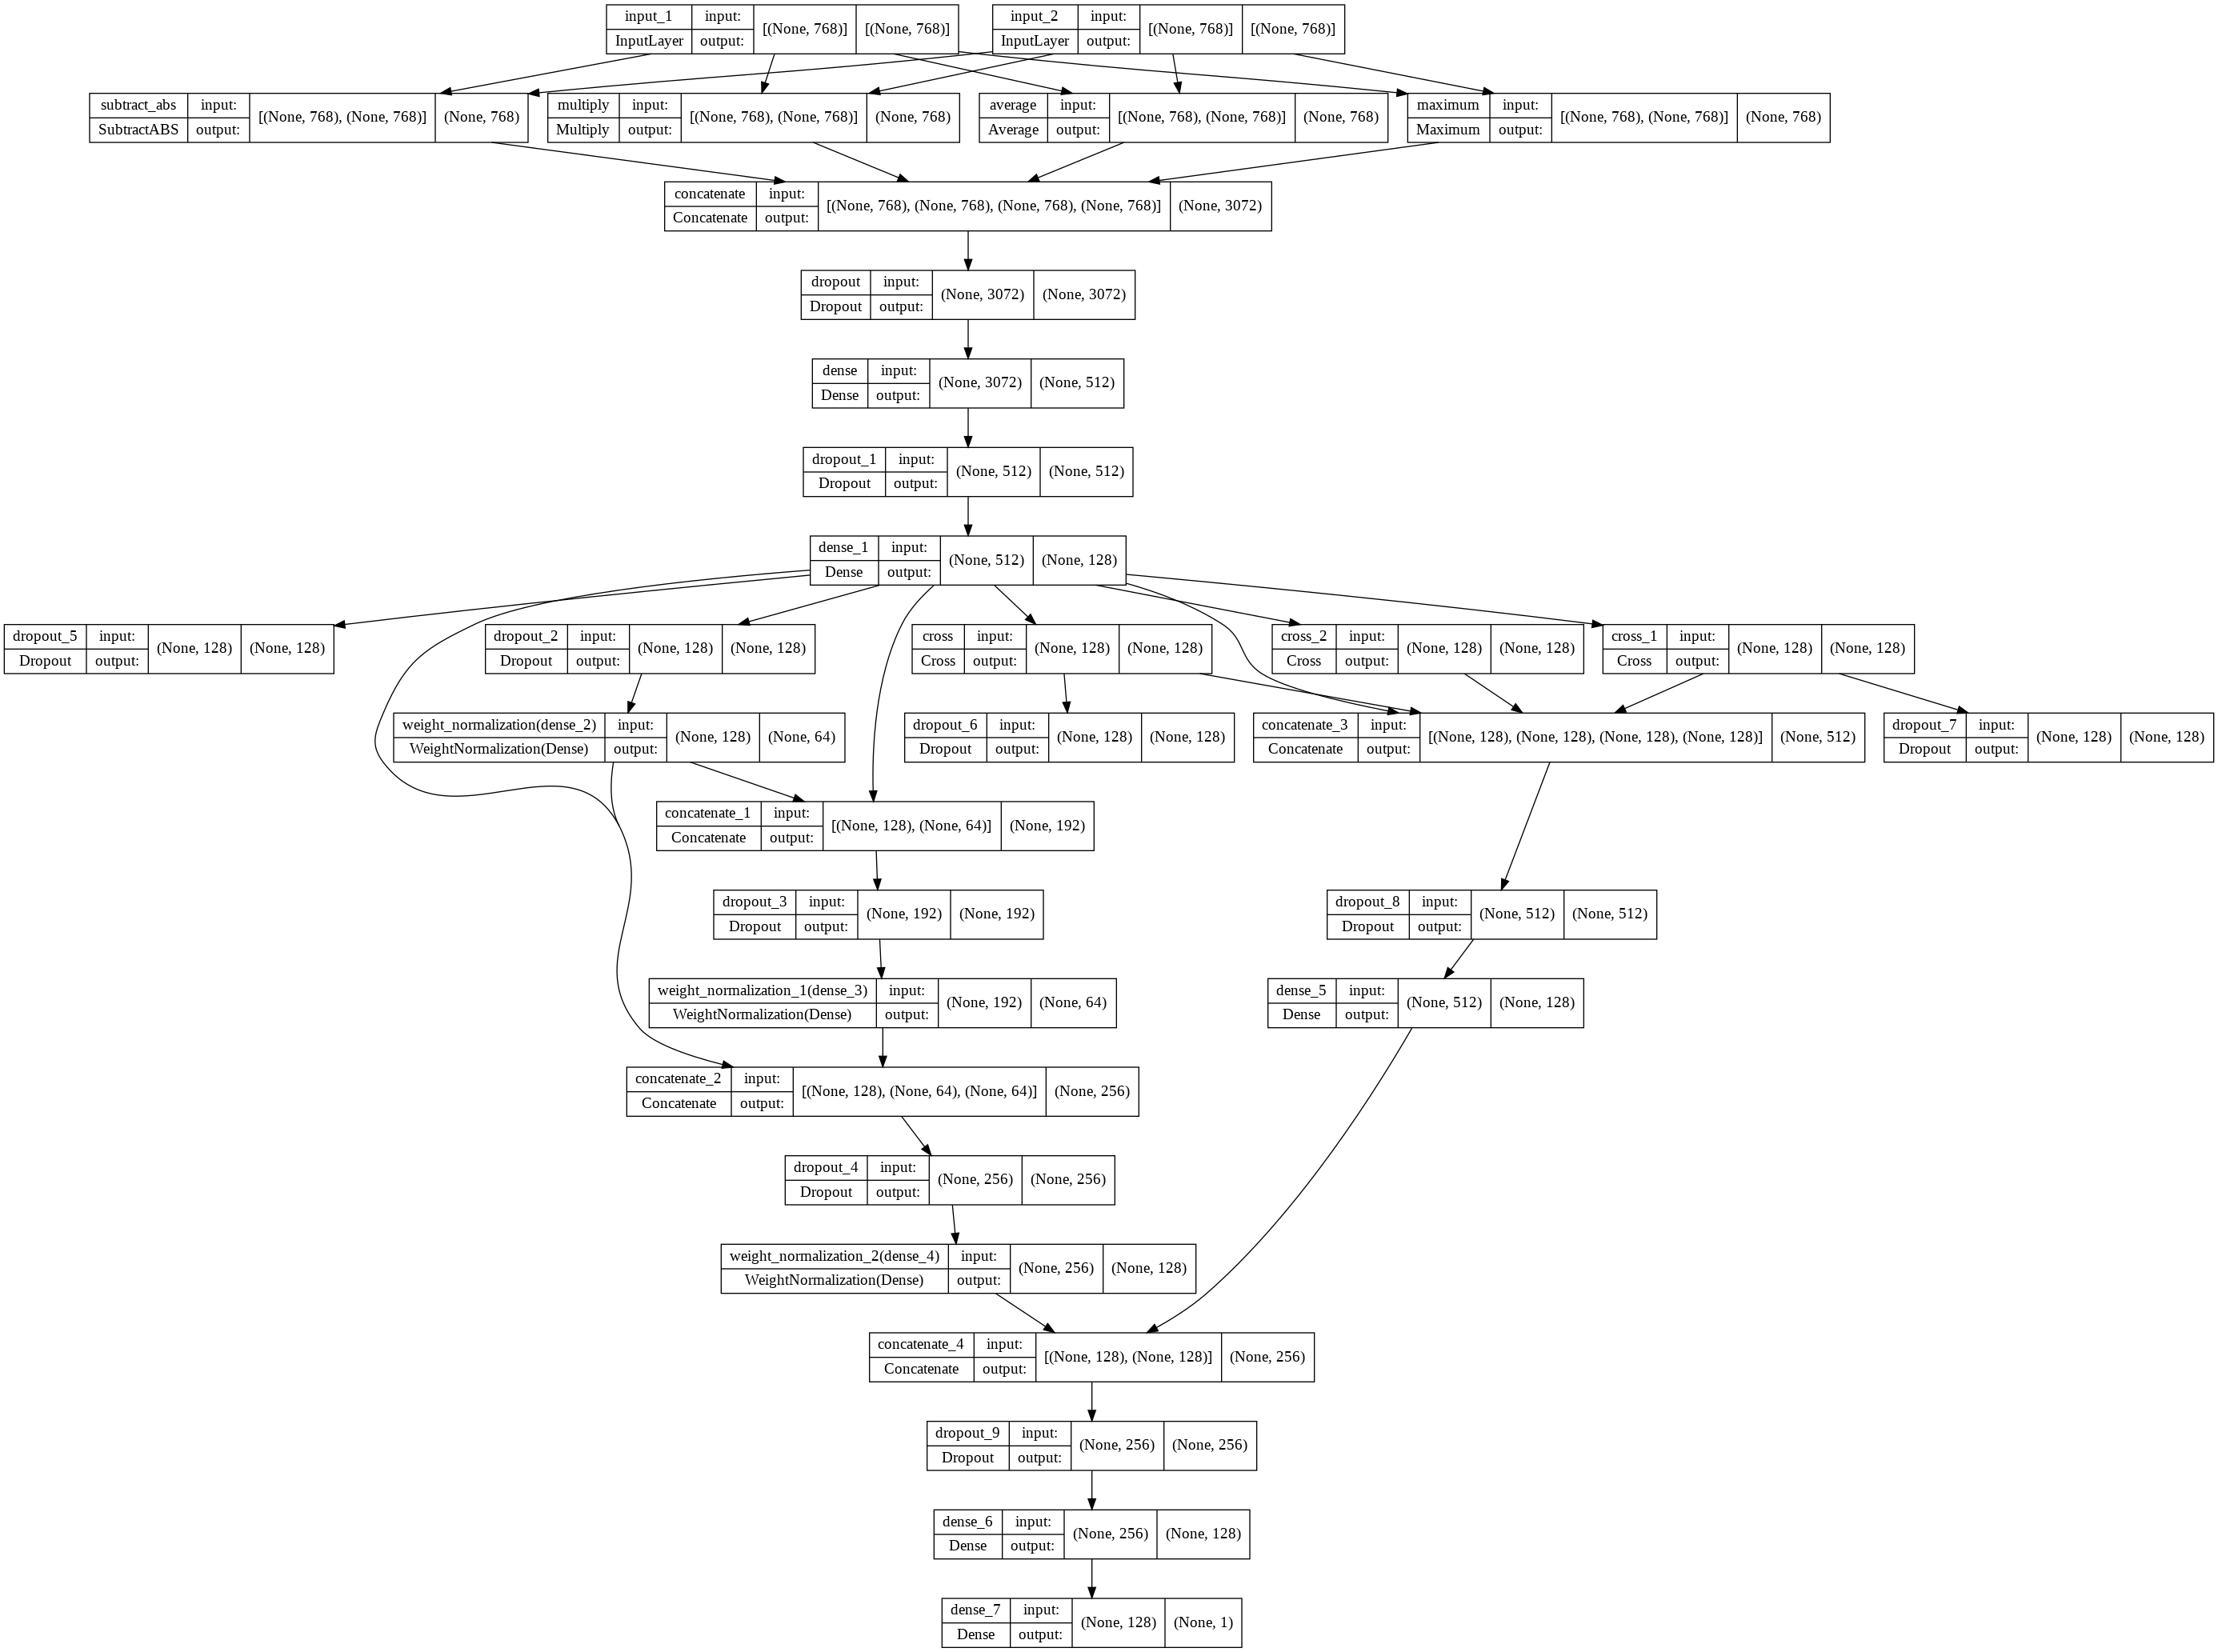

In [31]:
plot_model(tmp_model, show_shapes=True)

In [32]:
del tmp_model

# Training

In [33]:
def create_dataset(x, y, batch_size, shuffle=True, sample_weight=None):
    if sample_weight is not None:
        dataset = tf.data.Dataset.from_tensor_slices((x, y, sample_weight))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(int(batch_size * 4), reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

def get_pair_samples(idx_list, pos_nums_comb, pos_num_samples, neg_nums_comb, neg_num_samples, data_container=[], tfidf=None, tfidf_mode="fit", seed=42):

    # === positive pair 구성 ===
    # 코사인 유사도를 난이도로 간주한 후 난이도 구간 별로 sampling

    # 난이도 구간 설정
    n_difficulties = 5
    # sampling 된 datafame 변수에 대해 그룹별 pair를 추출하기 위한 unique group 변수 할당
    idx_unique = df_full.iloc[idx_list].index.get_level_values(0).unique()
    tfidf_corpus_idx = []
    tfidf_corpus_table = dataframe(columns=[0,1])

    np_rnd.seed(seed)
    pos_groups = idx_unique[np_rnd.choice(len(idx_unique), min(len(idx_unique), pos_nums_comb), replace=False)]
    print(f"positive population : {len(idx_unique)}")
    comb = None
    comb_counter = 0
    row_cnt = 0
    seed_counter = 0
    flag = True
    # group이 지정된 것 보다 적을경우 sample을 다시 계산하여 할당
    pos_num_samples = int(np.ceil((pos_nums_comb * pos_num_samples) / len(pos_groups)))
    print("pos_groups :", pos_groups.shape[0])
    print("pos_num_samples per group :", pos_num_samples)
    for group in tqdm(pos_groups, desc="positive group"):
        df_unique = df_full.iloc[idx_list].loc[group]

        comb = dataframe(list(itertools.combinations(df_unique.index, 2)))
        comb_counter += comb.shape[0]
        # # 그룹에서 각 코드의 조합을 산출 (n * n)
        # comb = list(itertools.combinations(df_unique.index, 2))
        # # 각 코드 조합에 따른 코사인 유사도 산출
        # comb = dataframe([(i, j, cos_sim(df_full_fv[group_idx[1].get_loc(i)], df_full_fv[group_idx[1].get_loc(j)])) for i, j in comb])
        # # calculate cosine similarity for getting difficulty
        # comb["difficulty"] = KBinsDiscretizer(n_difficulties, encode='ordinal', strategy='kmeans').fit_transform(comb.iloc[:,[2]]).flatten().astype("int32")
        try:
            # comb, _ = tts(
            #     comb.iloc[:-1,:],
            #     train_size=np.clip(pos_num_samples, comb.iloc[:-1,0].nunique(), len(comb.iloc[:-1,:])-comb.iloc[:-1,0].nunique()),
            #     test_size=comb.iloc[:-1,0].nunique(),
            #     stratify=comb.iloc[:-1,0], random_state=seed_counter
            # )
            comb, _ = tts(
                comb,
                train_size=max(1, min(comb.shape[0], pos_num_samples)-1),
                test_size=1,
                stratify=None, random_state=seed_counter
            )
            # comb = pd.concat([comb1, comb2], axis=0)
            # comb, _ = tts(
            #     comb.iloc[:-1,:],
            #     train_size=max(len(comb.iloc[:-1,:])-comb.iloc[:-1,0].nunique(), pos_num_samples),
            #     test_size=comb.iloc[:-1,0].nunique(),
            #     stratify=comb.iloc[:-1,0], random_state=seed_counter
            # )
            # np_rnd.seed(seed_counter)
            # comb = comb.iloc[np_rnd.choice(comb.shape[0], min(comb.shape[0], pos_num_samples), replace=False)]
            row_cnt += comb.shape[0]
            seed_counter += 1
            flag = True
        except:
            flag = False
        
        if flag:
            # output = [np.concatenate([df_full_fv[group_idx[1].get_loc(i)], df_full_fv[group_idx[1].get_loc(j)]], axis=0)[np.newaxis, ...] for i, j in zip(comb.iloc[:,0], comb.iloc[:,1])]
            tfidf_corpus_table = pd.concat([tfidf_corpus_table, comb], axis=0, ignore_index=True)
            # output = [np.concatenate([df_full_fv[group_idx[1].get_loc(i)], df_full_fv[group_idx[1].get_loc(j)]], axis=0)[np.newaxis, ...] for i, j in zip(comb.iloc[:,0], comb.iloc[:,1])]
            # data_container[0].append(np.concatenate(output, axis=0))
            # data_container[1].extend([1] * len(output))
            data_container[1].extend([1] * comb.shape[0])
    
    print("\ntotal combination :", comb_counter)
    print("positive samples", row_cnt)

    # === negative pair 구성 ===
    neg_groups = dataframe(list(itertools.combinations(idx_unique, 2)))
    print(f"\nnegative population : {len(neg_groups)}")
    neg_groups = neg_groups.sample(n=min(neg_groups.shape[0], neg_nums_comb), replace=False, random_state=seed) 
    comb = None
    comb_counter = 0
    row_cnt = 0
    seed_counter = 0
    flag = True
    # group이 지정된 것 보다 적을경우 sample을 다시 계산하여 할당
    neg_num_samples = int(np.ceil((neg_nums_comb * neg_num_samples) / len(neg_groups)))
    print("neg_groups :", neg_groups.shape[0])
    print("neg_num_samples per group :", neg_num_samples)
    for group0, group1 in tqdm(zip(neg_groups[0], neg_groups[1]), total=neg_groups.shape[0], desc="negative groups"):
        df_unique0 = df_full.iloc[idx_list].loc[group0]
        df_unique1 = df_full.iloc[idx_list].loc[group1]

        comb = dataframe(list(itertools.product(df_unique0.index, df_unique1.index)))
        comb_counter += comb.shape[0]

        # # 두 그룹 코드 id에 대해서 조합을 산출 (m * n)
        # comb = list(itertools.product(df_unique0.index, df_unique1.index))
        # # 각 코드 조합에 따른 코사인 유사도 산출
        # comb = dataframe([(i, j, cos_sim(df_full_fv[group_idx[1].get_loc(i)], df_full_fv[group_idx[1].get_loc(j)])) for i, j in comb])
        # # calculate cosine similarity for getting difficulty
        # comb["difficulty"] = KBinsDiscretizer(n_difficulties, encode='ordinal', strategy='kmeans').fit_transform(comb.iloc[:,[2]]).flatten().astype("int32")
        try:
            # comb, _ = tts(
            #     comb.iloc[:-1,:],
            #     train_size=np.clip(neg_num_samples, comb.iloc[:-1,0].nunique(), len(comb.iloc[:-1,:])-comb.iloc[:-1,0].nunique()),
            #     test_size=comb.iloc[:-1,0].nunique(),
            #     stratify=comb.iloc[:-1,0], random_state=seed_counter
            # )
            comb, _ = tts(
                comb,
                train_size=max(1, min(comb.shape[0], neg_num_samples)-1),
                test_size=1,
                stratify=None, random_state=seed_counter
            )
            # comb = pd.concat([comb1, comb2], axis=0)
            # comb, _ = tts(
            #     comb.iloc[:-1,:],
            #     train_size=max(len(comb.iloc[:-1,:])-comb.iloc[:-1,0].nunique(), neg_num_samples),
            #     test_size=comb.iloc[:-1,0].nunique(),
            #     stratify=comb.iloc[:-1,0],
            #     random_state=seed_counter
            # )
            # np_rnd.seed(seed_counter)
            # comb = comb.iloc[np_rnd.choice(comb.shape[0], min(comb.shape[0], neg_num_samples), replace=False)]
            row_cnt += comb.shape[0]
            seed_counter += 1
            flag = True
        except:
            flag = False
        
        if flag:
            # output = [np.concatenate([df_full_fv[group_idx[1].get_loc(i)], df_full_fv[group_idx[1].get_loc(j)]], axis=0)[np.newaxis, ...] for i, j in zip(comb.iloc[:,0], comb.iloc[:,1])]
            tfidf_corpus_table = pd.concat([tfidf_corpus_table, comb], axis=0, ignore_index=True)
            # data_container[0].append(np.concatenate(output, axis=0))
            # data_container[1].extend([0] * len(output))
            data_container[1].extend([0] * comb.shape[0])
    print("\ntotal combination :", comb_counter)
    print("neagative samples", row_cnt)

    # positive, negative 샘플 추출 후 tfidf 파라미터 학습 
    # tfidf 는 전체 train set 대상으로 학습
    # if tfidf_mode == "fit":
    #     tfidf.fit(df_full["tokens"].iloc[idx_list].apply(lambda x: " ".join(x)))
    #     # tfidf.fit(df_full["tokens"].loc[pd.IndexSlice[:, list(set(tfidf_corpus_table[0].tolist() + tfidf_corpus_table[1].tolist()))]].apply(lambda x: " ".join(x)))
    
    shuffled_idx = np_rnd.choice(tfidf_corpus_table.shape[0], tfidf_corpus_table.shape[0], replace=False)
    tfidf_corpus_table = tfidf_corpus_table.iloc[shuffled_idx]
    print("\noutput length :", tfidf_corpus_table.shape[0], "\n")

    output = [None, None, tfidf_corpus_table.shape[0]]
    # for tokens
    # output[0] = (
    #     # convert_sparse_matrix_to_sparse_tensor(tfidf.transform(df_full["tokens"].iloc[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[0].tolist()]].apply(lambda x: " ".join(x)))),
    #     # convert_sparse_matrix_to_sparse_tensor(tfidf.transform(df_full["tokens"].iloc[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[1].tolist()]].apply(lambda x: " ".join(x))))
    #     df_full["tokens"].iloc[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[0].tolist()]].apply(lambda x: " ".join(x)).to_frame(),
    #     df_full["tokens"].iloc[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[1].tolist()]].apply(lambda x: " ".join(x)).to_frame()
    #     # tfidf.transform(df_full["tokens"].iloc[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[0].tolist()]].apply(lambda x: " ".join(x))).todense(),
    #     # tfidf.transform(df_full["tokens"].iloc[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[1].tolist()]].apply(lambda x: " ".join(x))).todense()
    # )
    # for embedded vector
    output[0] = (
        df_full_fv[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[0].tolist()]],
        df_full_fv[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[1].tolist()]],
    )
    # # mean the inputs for learning bidirectioanl position, (A, B)'s result is equal to (B, A)'s one
    # output[0] = (tfidf.transform(df_full["tokens"].iloc[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[0].tolist()]].apply(lambda x: " ".join(x))).todense() + \
    #             tfidf.transform(df_full["tokens"].iloc[[group_idx[1].get_loc(i) for i in tfidf_corpus_table[1].tolist()]].apply(lambda x: " ".join(x))).todense()) / 2
    
    output[1] = series(data_container[1]).iloc[shuffled_idx].tolist()
    return output

def tf_metrics_auc_roc(y_true, y_pred):
    return tf.py_function(metrics.roc_auc_score, (tf.squeeze(y_true), tf.squeeze(y_pred)), tf.float32)

In [34]:
def do_fold_training(fold, train_idx, val_idx, sample_weight=None, finetuning=False):
    tmp_time = time()
    print("\n===== Fold", fold, "=====\n")

    # base set (1,000,000)
    pos_nums_comb = 200_000
    pos_num_samples = 1
    neg_nums_comb = 800_000
    neg_num_samples = 1

    # # large set (5,000,000)
    # pos_nums_comb = 1_000_000
    # pos_num_samples = 1
    # neg_nums_comb = 4_000_000
    # neg_num_samples = 1

    # # very large set (10,000,000)
    # pos_nums_comb = 2_000_000
    # pos_num_samples = 1
    # neg_nums_comb = 8_000_000
    # neg_num_samples = 1

    # ===== train =====
    # print("create train set")
    # tmp_x = []
    # tmp_y = []
    # get_pair_samples(
    #     train_idx,
    #     pos_nums_comb=pos_nums_comb, pos_num_samples=pos_num_samples,
    #     neg_nums_comb=neg_nums_comb, neg_num_samples=neg_num_samples,
    #     data_container=[tmp_x, tmp_y], seed=fold
    # )
    # print("expected samples :", pos_nums_comb * pos_num_samples + neg_nums_comb * neg_num_samples)
    # tmp_x = np.concatenate(tmp_x, axis=0)
    # tmp_y = array(tmp_y, dtype="float32")
    # # random shuffing pos, neg samples
    # shuffled_idx = np_rnd.choice(tmp_x.shape[0], tmp_x.shape[0], replace=False)
    # tmp_x = tmp_x[shuffled_idx]
    # tmp_y = tmp_y[shuffled_idx]
    # train_ds = create_dataset((tmp_x[:, :768], tmp_x[:, 768:]), tmp_y, batch_size, True, sample_weight)

    print("create train set")
    print("expected samples :", pos_nums_comb * pos_num_samples + neg_nums_comb * neg_num_samples)
    tmp_x = []
    tmp_y = []
    tmp_x, tmp_y, train_sample_length = get_pair_samples(
        train_idx,
        pos_nums_comb=pos_nums_comb, pos_num_samples=pos_num_samples,
        neg_nums_comb=neg_nums_comb, neg_num_samples=neg_num_samples,
        data_container=[tmp_x, tmp_y], tfidf=None, tfidf_mode="fit", seed=fold
    )
    # tmp_x, tmp_y, train_sample_length = get_pair_samples(
    #     train_idx,
    #     pos_nums_comb=pos_nums_comb, pos_num_samples=pos_num_samples,
    #     neg_nums_comb=neg_nums_comb, neg_num_samples=neg_num_samples,
    #     data_container=[tmp_x, tmp_y], tfidf=tfidf_list[-1], tfidf_mode="fit", seed=fold
    # )
    train_ds = create_dataset(tmp_x, tmp_y, batch_size, True, sample_weight)
    # input_length = len(tfidf_list[-1].vocabulary_)

    # ===== validation =====
    # print("create validation set")
    # tmp_x = []
    # tmp_y = []
    # get_pair_samples(
    #     val_idx,
    #     pos_nums_comb=pos_nums_comb, pos_num_samples=int(pos_num_samples / 5),
    #     neg_nums_comb=neg_nums_comb, neg_num_samples=int(neg_num_samples / 5),
    #     data_container=[tmp_x, tmp_y], seed=fold
    # )
    # print("expected samples :", pos_nums_comb * int(pos_num_samples / 5) + neg_nums_comb * int(neg_num_samples / 5))
    # tmp_x = np.concatenate(tmp_x, axis=0)
    # tmp_y = array(tmp_y, dtype="float32")
    # val_ds = create_dataset((tmp_x[:, :768], tmp_x[:, 768:]), tmp_y, batch_size, False)

    print("create validation set")
    print("expected samples :", pos_nums_comb * max(1, int(pos_num_samples / 5)) + neg_nums_comb * max(1, int(neg_num_samples / 5)))
    tmp_x = []
    tmp_y = []
    tmp_x, tmp_y, val_sample_length = get_pair_samples(
        val_idx,
        pos_nums_comb=int(pos_nums_comb / 5), pos_num_samples=max(1, int(pos_num_samples / 5)),
        neg_nums_comb=int(neg_nums_comb / 5), neg_num_samples=max(1, int(neg_num_samples / 5)),
        data_container=[tmp_x, tmp_y], tfidf=None, tfidf_mode="transform", seed=fold
    )
    # tmp_x, tmp_y, val_sample_length = get_pair_samples(
    #     val_idx,
    #     pos_nums_comb=pos_nums_comb, pos_num_samples=int(pos_num_samples / 5),
    #     neg_nums_comb=neg_nums_comb, neg_num_samples=int(neg_num_samples / 5),
    #     data_container=[tmp_x, tmp_y], tfidf=tfidf_list[-1], tfidf_mode="transform", seed=fold
    # )
    val_ds = create_dataset(tmp_x, tmp_y, batch_size, False)
    del tmp_x, tmp_y

    cb_tensorboard = tf_callbacks.TensorBoard(log_dir=tb_filepath, histogram_freq=1)
    
    try:
        wandb.tensorboard.patch(root_logdir=tb_filepath)
    except:
        pass
    wandb.init(
        project="dacon_code_similarity",
        group=model_name,
        name="fold_" + str(fold)
    ); wandb.config.step = 0

    # total_iter = int(np.ceil(train_sample_length / batch_size) * epochs)
    # SCHEDULE_BOUNDARIES = [int(total_iter*0.2), int(total_iter*0.4), int(total_iter*0.6), int(total_iter*0.8)]
    # lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries=SCHEDULE_BOUNDARIES,
    #     values=[1e-3, 5e-4, 1e-4, 5e-5, 1e-5],
    # )

    total_iter = int(np.ceil(train_sample_length / batch_size) * epochs)
    SCHEDULE_BOUNDARIES = [int(total_iter*0.2), int(total_iter*0.4), int(total_iter*0.6), int(total_iter*0.8)]
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=SCHEDULE_BOUNDARIES,
        values=[5e-4, 1e-4, 5e-5, 1e-5, 5e-6],
    )

    # total_iter = int(np.ceil(train_sample_length / batch_size) * epochs)
    # SCHEDULE_BOUNDARIES = [int(total_iter*0.2), int(total_iter*0.4), int(total_iter*0.6), int(total_iter*0.8)]
    # lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries=SCHEDULE_BOUNDARIES,
    #     values=[1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
    # )

    # total_iter = int(np.ceil(train_sample_length / batch_size) * epochs)
    # SCHEDULE_BOUNDARIES = [int(total_iter*0.2), int(total_iter*0.4), int(total_iter*0.6), int(total_iter*0.8)]
    # lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries=SCHEDULE_BOUNDARIES,
    #     values=[1e-5, 5e-6, 1e-6, 5e-7, 1e-7],
    # )

    # total_iter = int(np.ceil(train_sample_length / batch_size) * epochs)
    # SCHEDULE_BOUNDARIES = [int(total_iter*0.2), int(total_iter*0.4), int(total_iter*0.6), int(total_iter*0.8)]
    # lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries=SCHEDULE_BOUNDARIES,
    #     values=[1e-6, 5e-7, 1e-7, 5e-8, 1e-8],
    # )

    cb_earlyStopping = tf_callbacks.EarlyStopping(
        patience=patient_epochs, monitor='val_auc', mode='max'
    )
    cb_modelsave = tf_callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, monitor='val_auc', mode='max', save_weights_only=True, save_best_only=True
    )

    model = create_model()
    # model = create_model(input_length)
    model.compile(
        loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, label_smoothing=0.2),
        # loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
        # loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        # optimizer=tfa.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=weight_decay),
        metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.AUC(name="auc")]
    )
    
    print("start training")
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
            callbacks=[cb_modelsave, cb_earlyStopping, cb_tensorboard, TqdmCallback(verbose=1)])
    print("end training")

    model.load_weights(checkpoint_filepath)
    model.trainable = False
    model.save(folder_path + "architecture/" + model_name + "/fold_" + str(fold),
            options=tf.saved_model.SaveOptions(namespace_whitelist=["RandomInputExchange"]))
    history_list.append(history)
    
    fold_metric.append(model.evaluate(val_ds, return_dict=True, verbose=0))
    print(fold_metric[-1])

    wandb.log({"fold": fold,
               "loss": fold_metric[-1]["loss"],
               "accuracy": fold_metric[-1]["accuracy"],
               "auc": fold_metric[-1]["auc"]})
    wandb.finish()
    del train_ds, val_ds

    if os.path.exists(checkpoint_filepath):
        shutil.rmtree(checkpoint_filepath)
    if os.path.exists(tb_filepath):
        shutil.rmtree(tb_filepath)

    print("Fold " + str(fold) + " Time (minutes) : ", round((time() - tmp_time) / 60, 3))

In [35]:
# learning parameter setting
epochs = 20
patient_epochs = 10
batch_size = 64

eta = 1e-3 # fixed lr is replaced by lr scheduler 
weight_decay = 1e-4

checkpoint_filepath = './tmp_checkpoint/'
tb_filepath = "./tmp_tb/"

# test_pred = np.zeros(shape=(179700, 1))

In [36]:
n_folds = 5
group_spliter = GroupKFold(n_folds)
group_idx = (df_full.index.get_level_values(0), df_full.index.get_level_values(1))

In [ ]:
model_list = []
history_list = []
fold_metric = []
tfidf_list = []
seed_everything()

# 훈련데이터와 검증데이터를 그룹으로 분할
for fold, (train_idx, val_idx) in enumerate(group_spliter.split(df_full, groups=group_idx[0])):
    # break
    start_mem = memory_usage()
    do_fold_training(fold, train_idx, val_idx, sample_weight=None, finetuning=False)
    tf.keras.backend.clear_session()    
    gc.collect()
    end_mem = memory_usage()
    print("@Memory leaked :", end_mem - start_mem)

[debug] memory usage:   1878.277 MB

===== Fold 0 =====

create train set
expected samples : 1000000
positive population : 240
pos_groups : 240
pos_num_samples per group : 834


positive group: 100%|██████████| 240/240 [00:01<00:00, 127.62it/s]



total combination : 2637756
positive samples 199920

negative population : 28680
neg_groups : 28680
neg_num_samples per group : 28


negative groups: 100%|██████████| 28680/28680 [07:51<00:00, 60.88it/s]



total combination : 633804247
neagative samples 774360

output length : 974280 

create validation set
expected samples : 1000000
positive population : 60
pos_groups : 60
pos_num_samples per group : 667


positive group: 100%|██████████| 60/60 [00:00<00:00, 239.56it/s]



total combination : 659487
positive samples 39960

negative population : 1770
neg_groups : 1770
neg_num_samples per group : 91


negative groups: 100%|██████████| 1770/1770 [00:13<00:00, 135.32it/s]



total combination : 39119253
neagative samples 159300

output length : 199260 



wandb: Currently logged in as: frony. Use `wandb login --relogin` to force relogin


start training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
wandb.finish()
tf.keras.backend.clear_session()
gc.collect()

In [ ]:
# del df_full, df_full_fv
del df_full

# Inference

In [ ]:
# df_test = easyIO(None, folder_path + "datasets/corpus_test_tokens_prepV2.pkl", "r")
# df_test.drop(["code1", "code2"], axis=1, inplace=True)

In [ ]:
df_test_fv1 = easyIO(None, folder_path + "datasets/corpus_test_tokens_fv1V2.pkl", "r")
df_test_fv2 = easyIO(None, folder_path + "datasets/corpus_test_tokens_fv2V2.pkl", "r")

In [ ]:
# df_test.head()

In [ ]:
test_pred = np.zeros(shape=(179700, 1))
for fold in range(n_folds):
    folder_path + "architecture/" + model_name + "/fold_" + str(fold)
    test_ds = create_dataset(
        # (tfidf_list[fold].transform(df_test["tokens1"].apply(lambda x: " ".join(x))).todense(),
        # tfidf_list[fold].transform(df_test["tokens2"].apply(lambda x: " ".join(x))).todense()),
        # (df_test["tokens1"].apply(lambda x: " ".join(x)).to_frame(),
        # df_test["tokens2"].apply(lambda x: " ".join(x)).to_frame()),
        (df_test_fv1,
        df_test_fv2),
        None, batch_size, False
    )
    tmp_model = tf.keras.models.load_model(folder_path + "architecture/" + model_name + "/fold_" + str(fold),
                                           custom_objects={"RandomInputExchange": RandomInputExchange})
    test_pred[:,0] += tmp_model.predict(test_ds).flatten() / n_folds

# Submission

In [ ]:
submission = read_csv("/content/drive/MyDrive/Colab Notebooks/projects/Dacon/code_similarity/open.zip (Unzipped Files)/sample_submission.csv")

In [ ]:
submission.head()

In [ ]:
submission.shape

In [ ]:
submission["similar"] = [1 if i > 0.5 else 0 for i in test_pred[:,0]]
submission.head()

In [ ]:
submission.to_csv(folder_path + "architecture/" + model_name + "/testPred_" + model_name + ".csv", index=False)